In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Directorios de los datasets
train_dir = "datos/train"
val_dir = "datos/val"
test_dir = "datos/test"

In [ ]:
# Parámetros
img_size = (224, 224)
batch_size = 8
num_classes = 4  # Normal, Pólipos, Úlcera, Esophagitis

datagen_train = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,  # Rotación de hasta 45 grados
    width_shift_range=0.1,  # Desplazamiento horizontal del 10%
    height_shift_range=0.1,  # Desplazamiento vertical del 10%
    shear_range=0.1,  # Transformación de cizallamiento del 10%
    zoom_range=0.1,  # Zoom de hasta un 10%
    horizontal_flip=True,  # Volteo horizontal
    vertical_flip=True,  # Volteo vertical
    fill_mode='constant',  # Relleno con valores constantes
    brightness_range=[0.1, 1.0]  # Ajuste de brillo entre 0.1 y 1.0
)
 # Evitamos el sobreajuste
datagen_val_test = ImageDataGenerator(rescale=1.0/255)

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical' #salida formato one_hot encoding ya que hay mas de 2 clases
)

val_generator = datagen_val_test.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical', #salida formato one_hot encoding ya que hay mas de 2 clases
    shuffle=False
)

test_generator = datagen_val_test.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical', #salida formato one_hot encoding ya que hay mas de 2 clases
    shuffle=False
)

Found 3200 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


In [4]:
# Cargar modelo preentrenado ResNet50V2
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelamos las capas del modelo base

In [29]:
# Construcción del modelo
x = base_model.output

# Capa convolucional
x = Conv2D(filters=192, kernel_size=6, strides=1, padding='valid',
           activation='selu', kernel_initializer='lecun_normal')(x)

# Capa de Average Pooling 
x = AveragePooling2D(pool_size=2, strides=2, padding='valid')(x)

# Global Average Pooling para reducir dimensiones antes de la capa densa
x = GlobalAveragePooling2D()(x)

# Capa fully connected
x = Dense(512, activation='relu')(x)  # 512 neuronas

# Dropout ajustado 
x = Dropout(0.2)(x)  # Reducimos sobreajuste apagando el 20% de las neuronas

# Capa de salida con 4 clases y activación softmax
outputs = Dense(num_classes, activation='softmax')(x)

# Creación del modelo
model = Model(inputs=base_model.input, outputs=outputs)

In [30]:
# Compilación del modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #con funcion de perdida porque es multiclase

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet50v2_best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1) # Reduce LR si no hay mejora en 2 épocas

In [ ]:
# Entrenamiento del modelo
epochs = 25 # Puede detenerse antes si no mejora la validacion
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/25
400/400 [==============================] - 97s 224ms/step - loss: 1.4368 - accuracy: 0.8363 - val_loss: 1.4170 - val_accuracy: 0.8160 - lr: 0.0010
Epoch 2/25
400/400 [==============================] - 53s 133ms/step - loss: 0.3652 - accuracy: 0.9066 - val_loss: 0.4280 - val_accuracy: 0.9185 - lr: 0.0010
Epoch 3/25
400/400 [==============================] - 50s 125ms/step - loss: 0.2551 - accuracy: 0.9322 - val_loss: 0.3979 - val_accuracy: 0.9050 - lr: 0.0010
Epoch 4/25
400/400 [==============================] - 51s 127ms/step - loss: 0.2111 - accuracy: 0.9422 - val_loss: 0.1940 - val_accuracy: 0.9450 - lr: 0.0010
Epoch 5/25
400/400 [==============================] - 50s 125ms/step - loss: 0.2140 - accuracy: 0.9309 - val_loss: 0.1979 - val_accuracy: 0.9385 - lr: 0.0010
Epoch 6/25
400/400 [==============================] - ETA: 0s - loss: 0.1738 - accuracy: 0.9534
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
400/400 [=============================

In [33]:
# Guardar el modelo
model.save("resnet50v2_gastro_model.h5")
print("Modelo guardado")

Modelo guardado


In [48]:
# Evaluar en el conjunto de test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Evaluar en el conjunto de validación
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

100/100 [==============================] - 6s 59ms/step - loss: 0.0785 - accuracy: 0.9700
Test Accuracy: 97.00%
250/250 [==============================] - 13s 52ms/step - loss: 0.0926 - accuracy: 0.9645
Validation Accuracy: 96.45%


In [5]:
# Cargar el modelo guardado y probarlo
test_model = keras.models.load_model("resnet50v2_gastro_model.h5")

In [6]:
# Obtener predicciones para validación
y_true_val = val_generator.classes
y_pred_val = np.argmax(test_model.predict(val_generator), axis=1)

# Obtener predicciones para test
y_true_test = test_generator.classes
y_pred_test = np.argmax(test_model.predict(test_generator), axis=1)

# Reporte de clasificación para validación
print("\nValidation Classification Report:")
print(classification_report(y_true_val, y_pred_val, target_names=val_generator.class_indices.keys()))

# Reporte de clasificación para test
print("\nTest Classification Report:")
print(classification_report(y_true_test, y_pred_test, target_names=test_generator.class_indices.keys()))

100/100 [==============================] - 6s 58ms/step

Validation Classification Report:
                      precision    recall  f1-score   support

            0_normal       0.99      1.00      0.99       500
1_ulcerative_colitis       0.94      0.94      0.94       500
            2_polyps       0.94      0.95      0.94       500
       3_esophagitis       1.00      0.97      0.98       500

            accuracy                           0.96      2000
           macro avg       0.96      0.96      0.96      2000
        weighted avg       0.96      0.96      0.96      2000


Test Classification Report:
                      precision    recall  f1-score   support

            0_normal       0.99      1.00      0.99       200
1_ulcerative_colitis       0.96      0.96      0.96       200
            2_polyps       0.95      0.96      0.95       200
       3_esophagitis       0.99      0.96      0.98       200

            accuracy                           0.97       800
       

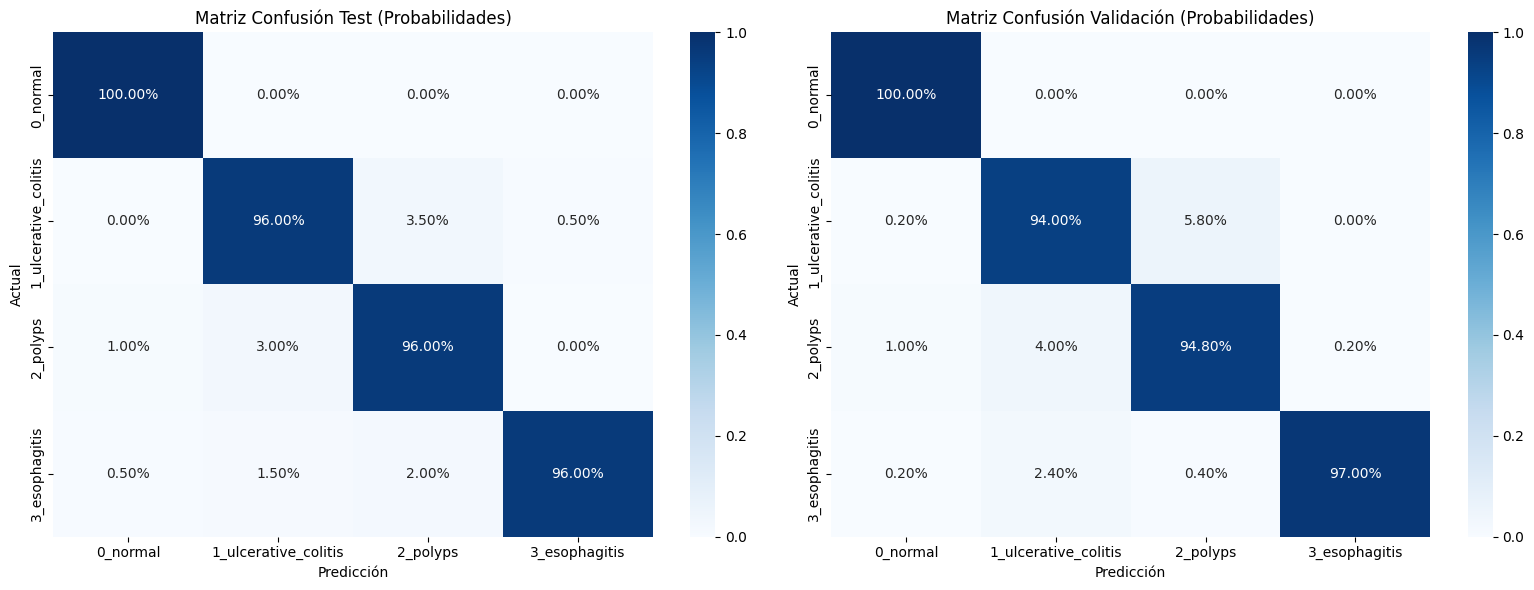

In [7]:
# Función para convertir la matriz de confusión a probabilidades
def confusion_matrix_prob(cm):
    return cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Matriz de confusión para el conjunto de test
cm_test = confusion_matrix(y_true_test, y_pred_test)
cm_test_prob = confusion_matrix_prob(cm_test)
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_test_prob, annot=True, fmt='.2%', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz Confusión Test (Probabilidades)')

# Matriz de confusión para el conjunto de validación
cm_val = confusion_matrix(y_true_val, y_pred_val)
cm_val_prob = confusion_matrix_prob(cm_val)
plt.subplot(1, 2, 2)
sns.heatmap(cm_val_prob, annot=True, fmt='.2%', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz Confusión Validación (Probabilidades)')

plt.tight_layout()
plt.show()

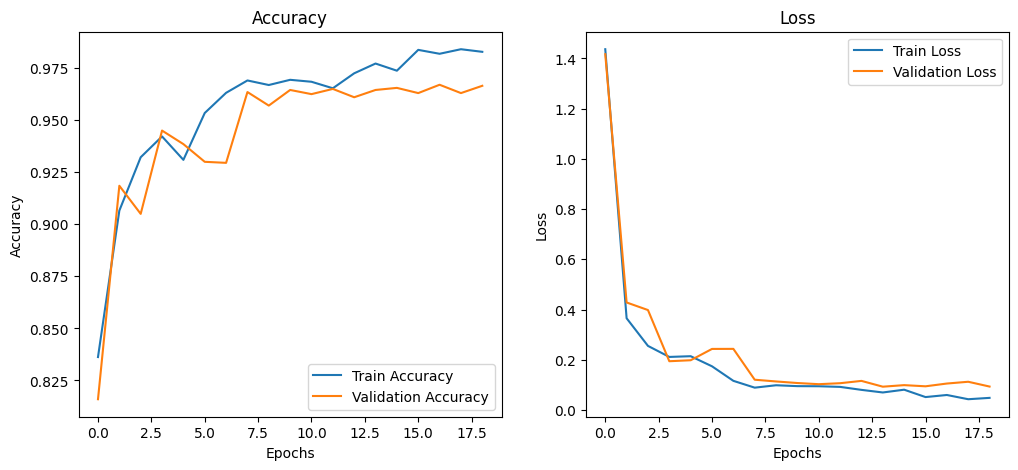

In [39]:
# Graficar la historia de entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()